# torchkeras.KerasModel ddp

# 一、环境准备

## 1.检查 CUDA 状态

多卡需禁用，或者运行后重启内核。

In [ ]:
import torch

def check_cuda():
    flag = torch.cuda.is_available()
    if flag:
        print("CUDA可使用")
    else:
        print("CUDA不可用")

    # 获取GPU数量
    ngpu = torch.cuda.device_count()
    print("GPU数量：",ngpu)
    # Decide which device we want to run on
    device = torch.device("cuda:1" if (torch.cuda.is_available() and ngpu > 0) else "cpu")
    print("驱动为：",device)
    print("GPU型号： ",torch.cuda.get_device_name(0))


check_cuda()

## 2.环境超参

In [ ]:
import sys
from argparse import Namespace

sys.path.append('..')

config = Namespace(
    batch_size = 256,
    num_workers = 2,
    lr = 1e-3,
    dropout_p = 0.1,
    epochs = 10,
    ckpt_path = 'checkpoint.pt',
    patience= 2, # 早停
)

## 3.DDP 前置 config

In [ ]:
import os
from accelerate.utils import write_basic_config
write_basic_config() 

# 二、数据准备

## 1.定义数据增强方式

In [ ]:
from torchvision import transforms

def create_transform():
    transform = transforms.Compose([transforms.ToTensor()])
    return transform, transform

## 2.定义 dataset 和 dataloader

In [ ]:
import torch
import torch.utils
import torchvision

def create_dataset():
    train_transform, val_transfom = create_transform()
    train_dataset = torchvision.datasets.MNIST(
        root="../datasets/mnist/", train=True, 
        download=True, transform=train_transform
    )
    train_dataset = torch.utils.data.Subset(
        train_dataset, indices=range(0, len(train_dataset), 5)
    )

    val_dataset = torchvision.datasets.MNIST(
        root="../datasets/mnist", train=False, 
        download=True, transform=val_transfom
    )
    return train_dataset, val_dataset

def create_dataloader():
    train_dataset, val_dataset = create_dataset()
    train_dataloader = torch.utils.data.DataLoader(
        train_dataset, batch_size=config.batch_size,
        shuffle=True, num_workers=config.num_workers
    )
    val_dataloader = torch.utils.data.DataLoader(
        val_dataset, batch_size=config.batch_size,
        shuffle=False, num_workers=config.num_workers
    )
    return train_dataloader, val_dataloader

## 3.检查数据

In [ ]:
%matplotlib inline
%config InlineBackend.figure_format = 'svg'

#visual some samples
from matplotlib import pyplot as plt

ds_train, ds_val = create_dataset()
dl_train, dl_val = create_dataloader()

for features,labels in dl_train:
    break
print(features.shape)
print(labels.shape)

plt.figure(figsize=(8,8)) 
for i in range(9):
    img,label = ds_train[i]
    img = img.permute(1,2,0)
    ax=plt.subplot(3,3,i+1)
    ax.imshow(img.numpy())
    ax.set_title("label = %d"%label)
    ax.set_xticks([])
    ax.set_yticks([]) 
plt.show()



# 三、训练准备

## 1.定义模型

In [ ]:
import torchkeras
import torch.nn as nn

def create_net():
    net = nn.Sequential()
    net.add_module("conv1",nn.Conv2d(in_channels=1,out_channels=512,kernel_size = 3))
    net.add_module("pool1",nn.MaxPool2d(kernel_size = 2,stride = 2)) 
    net.add_module("conv2",nn.Conv2d(in_channels=512,out_channels=256,kernel_size = 5))
    net.add_module("pool2",nn.MaxPool2d(kernel_size = 2,stride = 2))
    net.add_module("dropout",nn.Dropout2d(p = 0.1))
    net.add_module("adaptive_pool",nn.AdaptiveMaxPool2d((1,1)))
    net.add_module("flatten",nn.Flatten())
    net.add_module("linear1",nn.Linear(256,128))
    net.add_module("relu",nn.ReLU())
    net.add_module("linear2",nn.Linear(128,10))
    return net 

net = create_net()


## 2.定义 loss、optimizer、lr_scheduler、metrics_dict

In [ ]:
import torchmetrics # type: ignore
import torch.nn as nn
import torch

loss_fn = nn.CrossEntropyLoss()
optim = torch.optim.AdamW(
    params=net.parameters(), lr=config.lr
)
lr_scheduler = torch.optim.lr_scheduler.CosineAnnealingWarmRestarts(
    optimizer=optim, T_0=5
)
metrics_dict = {
    'acc': torchmetrics.Accuracy(
        task='multiclass', num_classes=10
    )
}

## 3.创建 torchkeras 模型

In [ ]:
from torchkeras.kerasmodel import KerasModel

model = KerasModel(net,loss_fn,metrics_dict,optim,lr_scheduler)

# 四、训练

## 1.单卡训练

In [ ]:
# dfhistory = model.fit(
#     train_data=dl_train,
#     val_data=dl_val,
#     epochs=config.epochs,
#     ckpt_path=config.ckpt_path,
#     patience=config.patience,
#     monitor='val_acc',
#     mode='max',
#     mixed_precision='no'
# )

## 2.多卡训练

注意：

1.多进程报错内存越界啥的，一般是进程中出现其他错误，需要进入进程debug。

2.dataloader 和多进程间存在问题，如果 len(dataloader)>2**15，使用多进程，并且 dataloader 使用了 shuffle = True，那么无法加载数据。

3.多进程结束时，会把 model 放置到 cpu，并且重新加载权重，这个时候会卡住。需要手动中断程序，并且重新加载模型。（后面又可以了，但是这里依旧不行。）

In [ ]:
args = dict(
    train_data = dl_train,
    val_data = dl_val,
    epochs=10,
    ckpt_path= config.ckpt_path,
    patience=2,
    monitor='val_acc',
    mode='max',
    callbacks=None,
    plot=True,
    wandb=False,
    quiet=None,
    mixed_precision='no'
)

model.fit_ddp(
    num_processes=2,
    **args
)

# 五、推理

y_pred =  2
y_prob =  0.9996340274810791


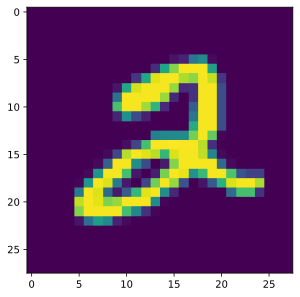

In [12]:
new_net = create_net()

model_clone = KerasModel(new_net,loss_fn,metrics_dict,optim,lr_scheduler)

model_clone.load_ckpt(config.ckpt_path)

net = model_clone.net
net.eval()

img, label = ds_train[1]

y_pred = torch.argmax(net(img[None,...])) 
y_prob = torch.softmax(net(img[None,...]),dim=-1).max() 

img = img.permute(1,2,0)
plt.imshow(img)
print('y_pred = ', y_pred.item())
print('y_prob = ', y_prob.item())